In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from ignite.metrics import Accuracy, Precision, Recall 
import pandas as pd
import re
from nltk.corpus import stopwords
import gc

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
def clean(doc, stop_words):
    '''Returns alphabetic-only, stop-words-free version of the given doc'''
    
    match = r'(?i)[^A-Z]' # match a non-alphabetic symbol
    alphabetic_only = re.sub(match, ' ', doc)
    terms = alphabetic_only.split()
    no_stop_words = [term for term in terms if term.lower() not in stop_words]
    clean_doc = ' '.join(no_stop_words)
    
    return clean_doc.lower()

In [4]:
stop_words = stopwords.words('english')

In [5]:
# first 5 stop words
stop_words[:5]

['i', 'me', 'my', 'myself', 'we']

In [6]:
df['comment_text'] = df['comment_text'].apply(lambda text: clean(text, stop_words))
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,aww matches background colour seemingly stuck ...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggestions improvement wondered sec...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0


In [7]:
def get_all_terms(corpus):
    '''Returns a list of all (including non-unique) terms in the corpus'''
    
    terms_in_corpus = []
    for doc in corpus:
        terms_in_corpus.extend(doc.split())
        
    return terms_in_corpus

In [8]:
terms_in_corpus = get_all_terms(df['comment_text'].values)

In [9]:
# first 5 terms in the corpus
terms_in_corpus[:5]

['explanation', 'edits', 'made', 'username', 'hardcore']

In [10]:
def count(iterable):
    '''Returns a dict where keys are unique objects of an iterable.
    Values are their amount in the whole iterable
    '''
    
    counter = {}
    for item in iterable:
        if item in counter:
            counter[item] += 1
        else:
            counter[item] = 1
            
    return counter

In [11]:
terms_dict = count(terms_in_corpus)
terms_s = pd.Series(terms_dict)
terms_s.sort_values(inplace=True, ascending=False)

In [12]:
# first 5 popular terms
terms_s[:5]

article      57738
wikipedia    48625
page         46542
talk         37908
please       29802
dtype: int64

In [13]:
# select most popluar words to reduce bag size
n_words_in_bag = 5000
top_terms = terms_s.index.values[:n_words_in_bag]

In [14]:
def doc_to_bag(doc, term_pool):
    '''Returns a dict where keys are term from the given pool
    and values are their amount in the given doc
    '''

    doc_terms = doc.split()
    intersect_term_pool = [term for term in doc_terms if term in term_pool] # to count only terms from given pool

    # managing docs which don't contain any term from the given pool
    if not intersect_term_pool:
        return {term_pool[0]: 0}
    
    return count(intersect_term_pool)

In [15]:
# build bag-of-words matrix
bag_of_words_dict = {}
bag_progress = tqdm(total=len(df['comment_text'].values), desc='Forming bag of words...')
for idx, doc in enumerate(df['comment_text'].values):
    bag_of_words_dict[idx] = doc_to_bag(doc, top_terms)
    bag_progress.update()
bag_progress.close()

In [16]:
bag_of_words_df = pd.DataFrame.from_dict(bag_of_words_dict, orient='index')
bag_of_words_df = bag_of_words_df.fillna(0).sort_index()
bag_of_words_df.head()

,explanation,edits,made,username,hardcore,fan,reverted,gas,voted,new,...,marcolfuck,boymamas,nikko,fucksex,bastered,fack,criminalwar,biznitch,youbollocks,aidsaids
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
dataset = np.array([[data, target] for data, target in zip(bag_of_words_df.values, df['toxic'].values)], dtype=object)
dataset = dataset[np.random.permutation(len(dataset))]

In [18]:
class Toxic(Dataset):
    
    def __init__(self, dataset, phase=None):
        
        self.dataset = dataset
        self.phase = phase

        
        if self.phase == 'train':
            start = 0
            end = int(0.5 * len(dataset.data))
        elif self.phase == 'val':
            start = int(0.5 * len(dataset.data))
            end = int(0.75 * len(dataset.data))
        elif self.phase == 'test':
            start = int(0.75 * len(dataset.data))
            end = len(dataset.data)
        else:
            start = 0
            end = len(dataset.data)
            
        self.data = self.dataset[start:end, 0]
        self.targets = self.dataset[start:end, 1]

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        data = self.data[idx].astype(np.float32)
        target = self.targets[idx].astype(np.float32)
            
        return data, target

In [19]:
train_set = Toxic(dataset, phase='train')
val_set = Toxic(dataset, phase='val')
test_set = Toxic(dataset, phase='test')

In [20]:
batch_size = 32
learning_rate = 0.001
num_epochs = 10

In [21]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [22]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_words_in_bag, 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 1)
        
        self.dropout = nn.Dropout(0.2)
        
        self.bn1 = nn.BatchNorm1d(num_features=512)
        self.bn2 = nn.BatchNorm1d(num_features=32)


        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.sigmoid((self.fc3(x)))
    
        return x

In [23]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
loss_fn = torch.nn.BCELoss()
device = 'cuda'
model.to(device)

Net(
  (fc1): Linear(in_features=5000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [25]:
total_progress = tqdm(total=num_epochs, desc='Total progress')
epoch_losses = []
accuracy = Accuracy()
epoch_accuracies = []

for epoch in range(num_epochs):

    model.train()
    epoch_progress = tqdm(total=len(train_loader), desc=f'Epoch {epoch}', leave=False)
    for data, target in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        target = target.unsqueeze(1)
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        epoch_progress.update()
    epoch_progress.close()
    
    model.eval()
    accuracy.reset()
    val_progress = tqdm(total=len(val_loader), desc=f'Epoch {epoch}. Validating...', leave=False)
    val_losses = []
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        target = target.unsqueeze(1)
        output = model(data)
        loss = loss_fn(output, target)
        val_losses.append(loss.item())
        accuracy.update(((output>.5).float(), target))
        val_progress.update()
    val_progress.close()    
        
    mean_val_loss = np.mean(val_losses)
    epoch_losses.append(mean_val_loss)
    current_accuracy = accuracy.compute()
    epoch_accuracies.append(current_accuracy)
    if current_accuracy == max(epoch_accuracies):
        torch.save(model, 'max_accuracy.pt')
        
    scheduler.step(mean_val_loss)
    
    print(f"Val loss {epoch}: {epoch_losses[-1]}")
    print(f"Val accuracy {epoch}: {epoch_accuracies[-1]}")
    
    total_progress.update()

total_progress.close()

Val loss 0: 0.283607053387471
Val accuracy 0: 0.9052214674253628


Val loss 1: 0.2683294403285338
Val accuracy 1: 0.906023613165217


Val loss 2: 0.21615020968408324
Val accuracy 2: 0.9180307322086582


Val loss 3: 0.35116358284570376
Val accuracy 3: 0.9060988143283283


Val loss 4: 0.2625105201506445
Val accuracy 4: 0.9145965457599078


Val loss 5: 0.23578239165682646
Val accuracy 5: 0.923370014789562



Val loss 6: 0.15410635659789312
Val accuracy 6: 0.9491389466823753


Val loss 7: 0.17126701243069403
Val accuracy 7: 0.9383601133030858


Val loss 8: 0.1571102465063023
Val accuracy 8: 0.948437069160003


Val loss 9: 0.14555266816557386
Val accuracy 9: 0.9541272905020931



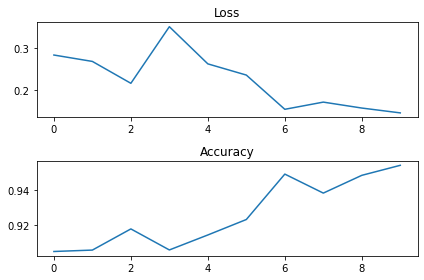

In [26]:
fig, axs = plt.subplots(2)
axs[0].plot(epoch_losses)
axs[0].set_title('Loss')
axs[1].plot(epoch_accuracies)
axs[1].set_title('Accuracy')
fig.tight_layout()

In [27]:
best_weights_model = torch.load('max_accuracy.pt')
best_weights_model.to(device)

Net(
  (fc1): Linear(in_features=5000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [28]:
accuracy = Accuracy()
accuracy.reset()

for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = best_weights_model(data)
        accuracy.update((output.round(), target.unsqueeze(1)))
        
print(accuracy.compute())

0.9533752788709798
